# Лабораторная работа 223: Интерференция квазимонохроматических волн 

In [290]:
from rich.console import Console
from rich.table import Table

import numpy as np
import matplotlib.pyplot as polt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from sklearn import linear_model  # для графиков МНК
import statsmodels.api as sm  # для коэф. МНК

console = Console()

In [291]:
# MEANS: экспериментальные r_m (радиусы колец начиная с 1 номера); размерность (до возведения в квадрат): 10^(-2) мм
experiment_values: dict[str, dict[str, np.ndarray]] = {
  # данные KDI:
  "yellow": {
    "bright": np.array([17, 27, 34.5, 40, 45, 49.5, 53.5, 57, 61, 64, 67.5, 70, 73, 76, 78.5, 81, 83.5, 86, 88, 90.5]),
    "dark": np.array([23, 31, 37.5, 43, 47.5, 51.5, 55.5, 59.5, 62.5, 66, 68.5, 72, 74.5, 77, 80, 82.5, 84.5, 87, 89.5, 91.5]),
  },
  "red": {
    "bright": np.array([91.5, 100, 106, 111, 115.5, 120, 124.3, 128, 131.5, 135, 138, 140.5, 143, 146.5, 149.5]),
    "dark": np.array([96, 103.5, 109, 114, 118.5, 122, 126, 130, 133.5, 136, 139.5, 142, 145, 148, 151])
  },
  # данные NIS:
  "green": {
    "bright": np.array([117, 127, 133, 138, 143, 147, 151, 154, 157, 160, 163, 166, 169, 172, 174, 177, 179, 181, 183, 185]),
    "dark": np.array([123, 130, 136, 141, 145, 149, 153, 156, 159, 162, 165, 168, 171, 173, 175, 178, 180, 182, 185, 187]),
  },
  "blue": {
    "bright": np.array([118, 126, 131, 136, 141, 144, 147, 150, 153, 156]),
    "dark": np.array([122, 129, 134, 138, 142, 146, 149, 152, 155, 158])
  }
}

# MEANS: центры соотв. окружностей, откуда начиналось измерение
centers: dict[str, float] = {
  "yellow": 1,
  "red": 66,
  "green": 95,
  "blue": 95,
}

In [292]:
colors = list(experiment_values.keys())
brightnesses = list(experiment_values[colors[0]].keys())

In [293]:
for color in colors:
  for brightness in brightnesses:
    experiment_values[color][brightness] = experiment_values[color][brightness].astype(float)

    # вычитаем начала измерений (центры нулевых колечек)
    experiment_values[color][brightness] -= centers[color]

    # и возводим в квадрат, т.к. МНК строится именно для r_m²


    experiment_values[color][brightness] **= 2

    # размерность (после возведения в квадрат): 10^(-4) мм², приводим в норму:
    experiment_values[color][brightness] *= 10**(-4)

In [294]:
# MEANS: словарь для запоминания коэф. k из МНК; размерность: мм²
mnk_coefs: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

# MEANS: словарь для запоминания стандарт. отклон. коэф. k из МНК; размерность: мм²
mnk_coefs_errors: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

$$
\begin{equation}
r_m = \sqrt{mR\lambda} \quad m=0,1,2...
\end{equation}
\\
\begin{equation}
r'_m = \sqrt{\frac{(2m-1)R\lambda}{2}}
\end{equation}
$$

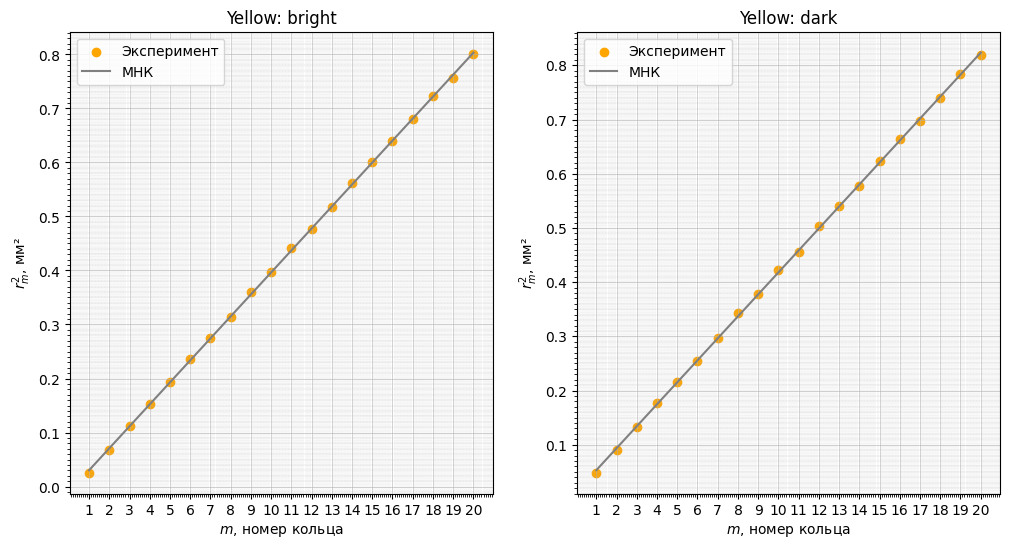

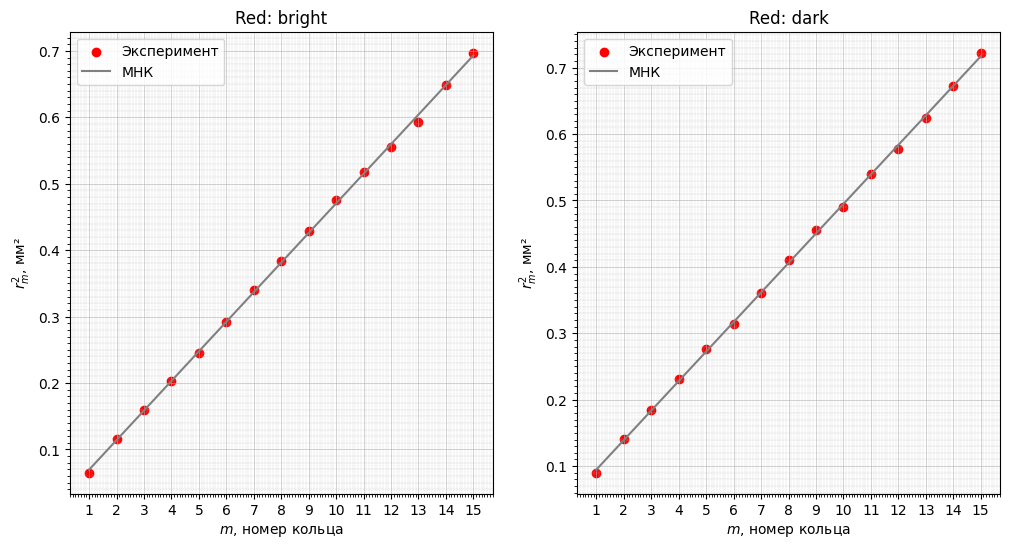

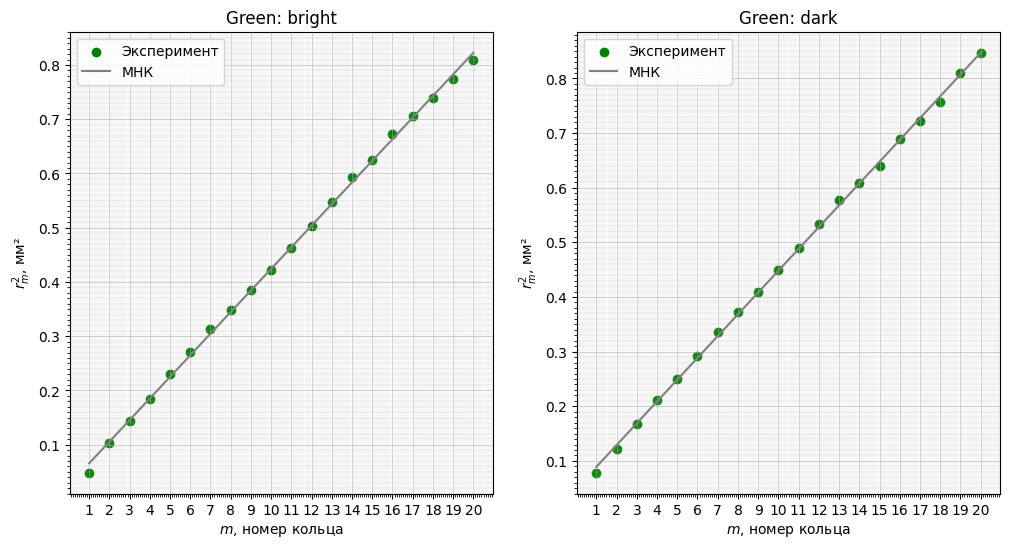

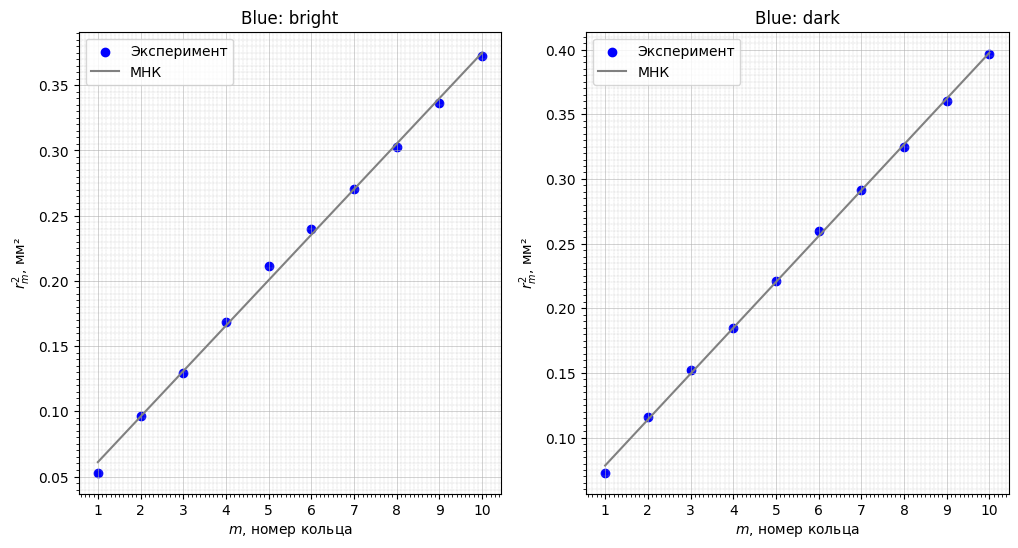

In [295]:
for color in colors:
  _, (ax_1, ax_2) = polt.subplots(1, 2, figsize=(12, 6))

  for ax, brightness in zip((ax_1, ax_2), brightnesses):
    # MEANS: номера точек (m по сути)
    m_points = np.arange(1, len(experiment_values[color][brightness]) + 1)

    X_sm = sm.add_constant(m_points)
    model_sm = sm.OLS(experiment_values[color][brightness], X_sm)
    results_sm = model_sm.fit()

    # размерность: мм²
    mnk_coefs[color][brightness] = results_sm.params[-1]
    mnk_coefs_errors[color][brightness] = results_sm.bse[-1]

    # (другой способ, отличия в 16-17 знаке)
    OLS = linear_model.LinearRegression()
    OLS.fit(X=m_points.reshape(-1, 1), y=experiment_values[color][brightness])
    # mnk_coefs[color][brightness] = OLS.coef_[-1]

    ax.set_title(f"{color.capitalize()}: {brightness}")

    ax.set_xlabel("$m$, номер кольца")
    ax.set_ylabel("$r_m^2$, мм²")

    ax.scatter(m_points,
               experiment_values[color][brightness],
               color=color if color != "yellow" else "orange",  # желтый сливается
               label="Эксперимент")

    # ax.scatter([0], [(centers[color] - centers[color])**2 * 10**(-4)],
    #            color="black",
    #            label="Центр")

    ax.plot(m_points,
            # использую его для графика
            OLS.predict(m_points.reshape(-1, 1)),
            color="gray",
            label="МНК")

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

    ax.grid(which='minor', linestyle='--', linewidth=0.2)
    ax.grid(which='major', linewidth=0.4)
    ax.legend()


polt.show()

In [296]:
table = Table(title="Коэффициенты МНК (k)")

table.add_column("Color", justify="center")

for color in colors:
  table.add_column(color.capitalize(), justify="center")

for brightness in brightnesses:
  table.add_row(brightness.capitalize(),
                *[f"k = {mnk_coefs[color][brightness]:.5f} мм²" for color in colors])

console.print(table)

                               Коэффициенты МНК (k)                               
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Color  ┃     Yellow      ┃       Red       ┃      Green      ┃      Blue       ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Bright │ k = 0.04068 мм² │ k = 0.04455 мм² │ k = 0.03984 мм² │ k = 0.03488 мм² │
│  Dark  │ k = 0.04053 мм² │ k = 0.04445 мм² │ k = 0.03989 мм² │ k = 0.03546 мм² │
└────────┴─────────────────┴─────────────────┴─────────────────┴─────────────────┘

## $ \text{2) Определение R и погрешности} \\ \text{его определения по методу МНК} $

$$
r_m = \sqrt{m  R  \lambda} \qquad
\begin{aligned}
  r_m^2 = mR\lambda, \qquad  m = x \qquad \\
  r^2 = kx + b,\qquad b = 0 \qquad \\
\end{aligned}
\implies \qquad
\begin{aligned}
  R\lambda=k \\
  R=\frac{k}{\lambda} \\
\end{aligned}
$$

$$ \text{Погрешности:} $$
$$
\begin{align*}
R &= \frac{k}{\lambda} = k \lambda^{-1} \quad & k \pm \Delta k \\
& & \lambda \pm \Delta \lambda \\
\frac{\Delta R}{R} &= \sqrt{1^2 \cdot \left(\frac{\Delta k}{k}\right)^2 + (-1)^2 \cdot \left(\frac{\Delta \lambda}{\lambda}\right)^2} \\
\Rightarrow \Delta R &= R \cdot \sqrt{\left(\frac{\Delta k}{k}\right)^2 + \left(\frac{\Delta \lambda}{\lambda}\right)^2}
\end{align*}
$$

In [297]:
# MEANS: диапазоны длин волн соотв. спектров
lambda_ranges = {
    "yellow": [565, 590],
    "red": [600, 740],
    "blue": [440, 500],
    "green": [500, 565]
}

# MEANS: словарь длин волн для соотв. цветов (как среднее диапазона); размерность: мм
optical_lambda: dict[str, float] = {
    color: np.mean(lambda_range).astype(float) * 10**(-6)
    for color, lambda_range in lambda_ranges.items()
}

# MEANS: словарь полуширин диапазонов длин волн для соотв. цветов; размерность: мм
optical_lambda_errors: dict[str, float] = {
    color: (lambda_range[1] - lambda_range[0]) / 2 * 10**(-6)
    for color, lambda_range in lambda_ranges.items()
}

In [298]:
# MEANS: словарь радиусов кривизны линзы для соотв. цветов; размерность: мм
R: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

# MEANS: словарь погрешностей радиусов кривизны линзы для соотв. цветов; размерность: мм
R_errors: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

# (расчет по затеханным формулам выше)
for color in colors:
  for brightness in brightnesses:
    R[color][brightness] = mnk_coefs[color][brightness] / optical_lambda[color]

    R_errors[color][brightness] = R[color][brightness] * np.sqrt(
      (mnk_coefs_errors[color][brightness] / mnk_coefs[color][brightness])**2 +
        (optical_lambda_errors[color] / optical_lambda[color])**2)

In [299]:
table = Table(title="Радиус кривизны линзы (R)")

table.add_column("Color", justify="center")

for color in colors:
  table.add_column(color.capitalize(), justify="center")

for brightness in brightnesses:
  table.add_row(brightness.capitalize(),
                *[f"R = {R[color][brightness]:.2f} ± {R_errors[color][brightness]:.2f} мм" for color in colors])

console.print(table)

                                    Радиус кривизны линзы (R)                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Color  ┃       Yellow        ┃         Red         ┃        Green        ┃        Blue         ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Bright │ R = 70.44 ± 1.54 мм │ R = 66.49 ± 6.96 мм │ R = 74.82 ± 4.60 мм │ R = 74.21 ± 4.91 мм │
│  Dark  │ R = 70.19 ± 1.54 мм │ R = 66.34 ± 6.94 мм │ R = 74.92 ± 4.59 мм │ R = 75.44 ± 4.86 мм │
└────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────────────┘

## $ \text{3) Исследование биений} $

![](./pictures/KDI.jpg)

![](./pictures/NIS.jpg)

## $ \text{4) Доплеровская ширина} $

$$
T = 900 \, K; \qquad \frac{\Delta\lambda}{\lambda} = ? \\
\frac{\Delta\lambda}{\lambda} ≈ \frac{V_m}{c} - эффект \, Доплера \\
V_m = \sqrt{\frac{8RT}{\pi\mu}}, \, \mu  = 200.6 \, \frac{г}{моль} \, (ртуть); \, V_m=308.7 \, \frac{м}{с} \\ 
\frac{\Delta\lambda}{\lambda} ≈ 10^{-6}
$$